# FM or bust 

Let's get started, shall we?  This is our first bit of notebook code, so here's a quick run-down on using the environment.

The notebook environment is made up of "cells", these little boxes of text.  Each cell has space for its output right below it, so they're kind of a nicely bundled-up REPL, in a web browser.  It's possible for that output to be graphical, which allows us to get graphs right next to the code that generates them.  Also, the cells come in different types: this one is a "markdown" cell, which contains markdown (a markup language for text, not proper code).  The ones below are also python cells, which you can run by hitting Shift-enter while they're selected.  If you're at the end of the notebook, it automatically includes a new cell for you.  If you want to add a new cell, there's menus up top that let you do this.  Alternately, the notebook environment is very keyboard-friendly, and you can hit Control-m and then 'h' to get a cheatsheet.

The python cells run against a "kernel" on the computer.  This is a slightly different kernel than you're used to: it's neither an operating system's core management routine, nor is it a bundle of convolution coeffients.  Instead, it's just a python process that takes code as input and spits back data as output.

So, with all that out of the way, let's go!

## Boilerplate

This is python, so there isn't supposed to be boilerplate, but, there is.  Below, we do
> %pylab inline

which is an IPython magic command (literally what they call it).  In this case, it does a bunch of imports for us: numpy is available as np, setting up matplotlib, and pulling the matplotlib helper functions into our top-level namespace.  This causes a bit of namespace pollution, so we have to be a little careful with all the new global variables, but it's not too bad.  When you pull this code out into your own standalone python programs, you'll want to do a bit of iteration to figure out how best to cope (which may be: run under IPython instead of python, as IPython can be used that way).

Anyway, here, we're pulling in pylab, which is a python matlab-alike (matlab is a mathematical programming environment).  We also set a new default figure size, as the original default is too small.

If you do this multiple times, you may get a warning about having clobbered variables: this is probably okay, but this goes back to the fact that pylab sprays stuff all over the global namespace.

In [16]:
%pylab inline
pylab.rcParams["figure.figsize"] = (15,5)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Next, we import the python rtl-sdr library.  This is available via `pip` as `pyrtlsdr`; you'll also need the `librtlsdr-dev` package (or comparable) from your distribution.  If it doesn't offer one, the rtl-sdr software is pretty straightforward to build from source, and available from github (no links here, as these things tend to move around over time: it's better to just google it and go from there).

In [17]:
from rtlsdr import RtlSdr

Now, let's set up our data slurping: we want to capture 104.5, which is KFOG here in San Francisco.  You'll want to change this $\mathrm{Fc}$ (Carrier Frequency) to match some local station where you are.  You may also need to tweak the gain a bit to get a value that works better for you.  One big gotcha here: if the gain is set too high, you won't be able to hear the audio.  Having the gain set too high is kind of like setting too long an exposure on a camera, and having the picture be nothing but shades of white.  Having it set too low is proabably okay, so start out low and work your way up.

$N$ here determines how many samples to capture.  At a value of $\mathrm{2 * Fs}$, it's going to pull in 2 seconds of signal.

In [18]:
Fc = 104.5e6      # Center frequency
Fs = 1024000      # Sample rate

N = int(2 * Fs) # Pull in this many samples
gain = 0.9     # Gain

Now, let's grab some samples, and see if we've captured a station.  If your graph looks something like the one below, you're good.  You should see a big peak in the middle.  The two square bumps on either side may or may not be there: they're digital subcarriers.  We're going to ignore those: all our information is captured within that main central hump.

This graph is a Power Spectral Density plot, or PSD for short.  A PSD plot shows us how much power is contained at various frequencies in our signal.  And, yes, frequencies can be negative, but we'll come back to that in the trigonometry chapter (it has to do with I/Q signals).

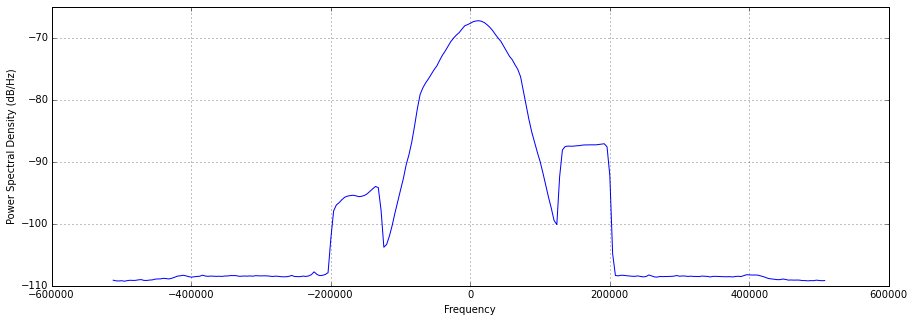

In [19]:
sdr = RtlSdr()
# configure device
sdr.sample_rate = int(Fs) # Hz
sdr.center_freq = int(Fc) # Hz
sdr.gain = gain

# Read samples
samples = sdr.read_samples(N)
sdr.close()
del(sdr)

psd(samples, Fs=Fs); None

Let's check out what we have for data here: we have a `numpy.ndarray` instance, containing `complex128` values, and which is a vector of length 2,048,000.  The `numpy.ndarray` is an N-dimensional array; we use `samples.shape` to see what its dimensions are.  We use `samples.dtype` to find out what it's an array of (numpy supports lots of types).  The type here is `complex128`, which is 128-bit complex floating point numbers, with 64 bits for both the real and imaginary parts.

The complex numbers in `samples` are In-phase/Quadrature samples, or I/Q samples.  We'll come back to that in a while.  Let's also take a quick look at the data itself.  Note that we skip the head of the data: sometimes the first few samples are wonky.  This is a general problem in these kinds of systems, as the tuners we can buy for $20 online aren't exactly the theoretical ideal devices.

In [20]:
samples.__class__, samples.dtype, samples.shape

(numpy.ndarray, dtype('complex128'), (2048000,))

In [21]:
samples[0:10]

array([-0.00392157-0.00392157j, -0.00392157+0.00392157j,
       -0.00392157+0.00392157j,  0.00392157-0.00392157j,
        0.00392157-0.00392157j, -0.00392157-0.00392157j,
       -0.00392157+0.00392157j, -0.00392157-0.00392157j,
       -0.00392157-0.00392157j, -0.00392157+0.00392157j])

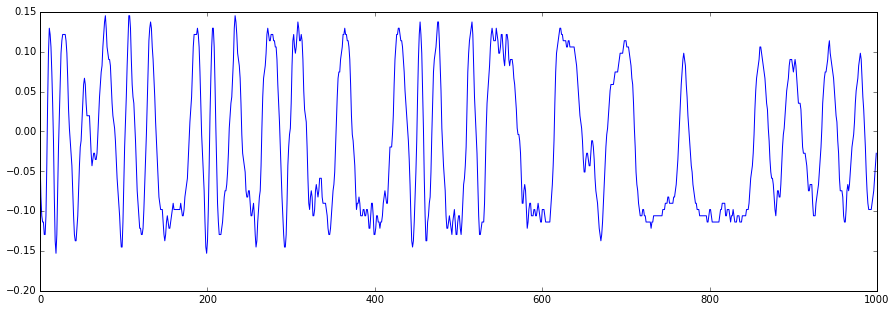

In [22]:
i0 = 100000
di = 1000
plot(samples[(i0):(i0+di)])

Now, we're going to demodulate the FM signal we captured, which will give us audio at the same sample rate as our radio.  This is slightly awkward, as high-quality CD audio is 44,100 samples per second, but we've got 1,024,000, just a tiny bit higher.  We'll come back to that.

We also look at the PSD of the audio we decoded, to see how it looks.  It looks like all our power is concentrated down well below 100kHz, which is what we expect.  The audio itself should be below 16kHz, with some other stuff under 60kHz.

In [23]:
def demod_pm(x, gain=1.0):
    xp = x[1:] * np.conj(x[:-1]) 
    retval = gain * np.arctan2(np.imag(xp), np.real(xp))
    return retval

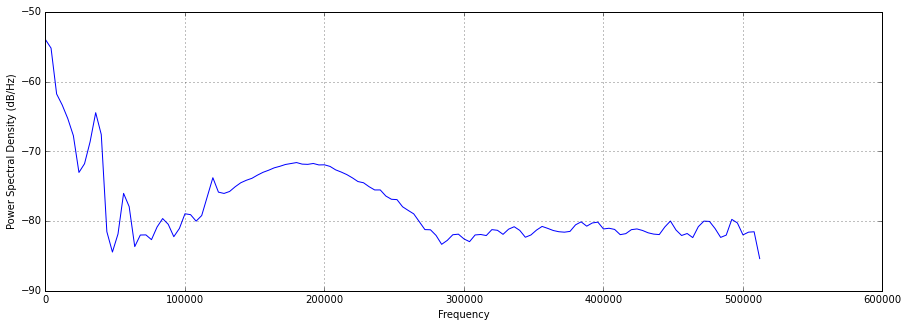

In [24]:
audio = demod_pm(samples)
psd(audio, Fs=Fs); None

Now, audio sampled at 1,024,000 Hz is pretty cool, but it's not something we can play for ourselves.  We'd like to get it down to 44,100 Hz, which is a common sample rate used in audio processing.  Unfortunately, samples are discrete, so we can only get it into the ballpark for now.  It looks like we can get to 44,521 Hz sample rates, which is close enough to hear whether or not the decode is working.  Later on, we'll learn how to fix up the sample rate properly, but, for now, we just live with music that's slightly faster than expected.

After we downsample to our expected rate, we take a quick look at the PSD to make sure it's not crazy, and it looks reasonable.

44521

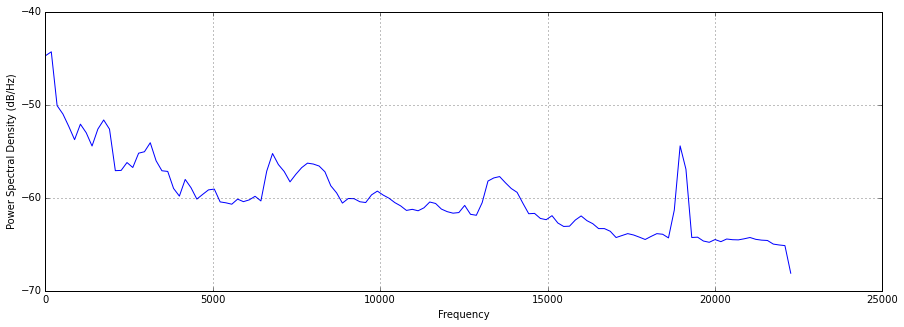

In [25]:
target_rate = 44100
downsample_ratio = int(Fs/target_rate)

Fa = Fs / downsample_ratio

audio_downsampled = audio[np.arange(0, len(audio), downsample_ratio)]

psd(audio_downsampled, Fs=Fa); Fa

Now, let's see what the audio itself looks like.  One way to visualize this is a spectrogram, which is kind of like the PSD, but showing us power over time.  Along the x-axis here is time, going from 0.0 to 2.0 seconds.  Along the y axis are frequencies, going from 0 Hz up to 22,050 Hz.  Each column up and down here is a color-coded version of the PSD for a small slice of time.  This allows us to see the structure of our signals over time, which is often very handy.

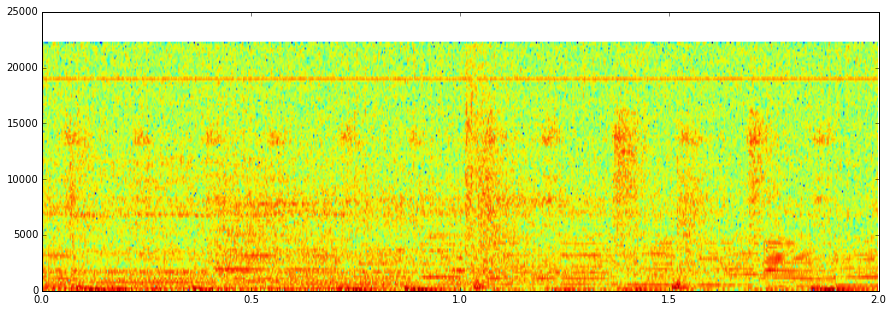

In [26]:
specgram(audio_downsampled, Fs=Fa); None

For giggles, let's take the audio and put it into a wav file we can listen to.  In the code here, we put in the actual audio rate we obtained (44,521Hz), which isn't standard.  Some programs will play this, others won't.  You may need to override the Fa with 44100 to get a wav file your player can cope with.

In [27]:
audio_downsampled.dtype

dtype('float64')

In [28]:
np.min(audio_downsampled), np.max(audio_downsampled)

(-1.5707963267948966, 3.1415926535897931)

In [29]:
import scipy.io.wavfile

In [30]:
scipy.io.wavfile.write("foo.wav", int(Fa), audio_downsampled)

## Conclusion

So, with all that code up there, we've captured our first signal, demodulated the FM to get the audio out, and gotten it into a format we can kind of sort of play.  Don't worry if there are parts you don't understand: we're consciously choosing not to explain everything here.  That's what the rest of this book is for.  Hopefully this exercise whetted your appetite for more SDR goodness, and will come along with us as we explain all the details.  Also, all of this is a bit duct tape and bailing wire, so we'll be making things better and more reliable as we go forward.